# Finding optimal local alignment across all possible translations of a DNA string

In this excercise we concern ourselves with the problem of finding the best local alignment across all possible translations of a DNA string, i.e. assuming the standard codon table and considering all possible frames.

## Smith-Waterman algorithm

First, we will re-implement the standard algorithm local alignment. (Credits to [radaniba](https://gist.github.com/radaniba/11019717)).

In [21]:
MATCH = 2
MISMATCH = -1
GAP = -1  # we're using linear gap penalty
END, DIAG, UP, LEFT = range(4)


def create_score_matrix(s1, s2):
    '''Create a matrix of scores representing trial alignments between two sequences.
    The path with the highest cummulative score is the best alignment.
    '''
    rows, cols = len(s1)+1, len(s2)+1
    score_matrix = [[0 for col in range(cols)] for row in range(rows)]

    max_score = 0
    max_pos = None    # The row and column of the highest score in matrix.
    for i in range(1, rows):
        for j in range(1, cols):
            score = calc_score(score_matrix, i, j, s1, s2)
            if score > max_score:
                max_score = score
                max_pos = (i, j)

            score_matrix[i][j] = score

    assert max_pos is not None, 'the x, y position with the highest score was not found'

    return score_matrix, max_pos, max_score


def calc_score(matrix, x, y, seq1, seq2):
    '''Calculate score for a given x, y position in the scoring matrix.
    The score is based on the up, left, and upper-left neighbors.
    '''
    similarity = MATCH if seq1[x - 1] == seq2[y - 1] else MISMATCH

    diag_score = matrix[x - 1][y - 1] + similarity
    up_score   = matrix[x - 1][y] + GAP
    left_score = matrix[x][y - 1] + GAP

    return max(0, diag_score, up_score, left_score)


def traceback(score_matrix, start_pos, s1, s2):
    '''Find the optimal path through the score matrix. This is done by 
    tracing a path from the bottom-right to the top-left corner of the scoring matrix. 
    Each move corresponds to a match, mismatch, or gap in one or both of the sequences being aligned.
    '''
    aligned_seq1, aligned_seq2 = [], []
    x, y = start_pos
    move = select_next_move(score_matrix, x, y)
    while move != END:
        if move == DIAG:
            aligned_seq1.append(s1[x - 1])
            aligned_seq2.append(s2[y - 1])
            x -= 1
            y -= 1
        elif move == UP:
            aligned_seq1.append(s1[x - 1])
            aligned_seq2.append('-')
            x -= 1
        else:
            aligned_seq1.append('-')
            aligned_seq2.append(s2[y - 1])
            y -= 1

        move = select_next_move(score_matrix, x, y)

    aligned_seq1.append(s1[x - 1])
    aligned_seq2.append(s2[y - 1])

    return ''.join(reversed(aligned_seq1)), ''.join(reversed(aligned_seq2))

def select_next_move(score_matrix, x, y):
    moves = {
        END: 0,
        DIAG: score_matrix[x - 1][y - 1], # match/mismatch
        UP: score_matrix[x - 1][y],  # gap in sequence 1
        LEFT: score_matrix[x][y - 1]  # gap in sequence 2
    }
    return max(moves, key=moves.get)


def align(seq1, seq2):
    score_matrix, max_pos, mac_score = create_score_matrix(seq1, seq2)
    return traceback(score_matrix, max_pos, seq1, seq2), mac_score, score_matrix

def show_matrix(matrix, seq1, seq2):
    import seaborn as sns
    from matplotlib import pyplot as plt
    fig, ax = plt.subplots(figsize=(8, 8))
    ax = sns.heatmap(matrix, square=True, yticklabels=' ' + seq1, xticklabels=' ' + seq2, 
                      annot=True, linewidths=.5, ax=ax, fmt='d', cbar=False)

(('A--T-C-G', 'ACATTCAG'), 6)

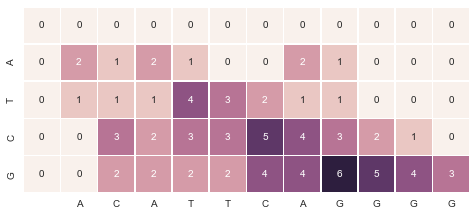

In [28]:
s1, s2 = 'ATCG', 'ACATTCAGGGG'
strings, score, matrix = align(s1, s2)
show_matrix(matrix, s1, s2)
strings, score

## First approximation

Let us start with two simplifying assumptions: that mutations (insertions and deletions) only occur on triplets of nucleotides and that they always match current frame.

In [88]:
def get_all_frames(seq1, seq2):
    frames = []
    for i in range(3):
        for j in range(3):
            s1, s2 = seq1[i:], seq2[j:]
            frames.append((i, j, s1, s2))
    return frames

In [89]:
seq1 ='ATGTCCGGTGGTAAAGGTGGTAAAGCTGGTTCAGCTGCTAAAGCTTCTCAATCTAGATCT'
seq2 = 'TACGCCCAAAGAATTGGTTCTGGTGCTCCAGTCTACTTGACTGCTGTCTTGGAATATTTG'
get_all_frames(seq1, seq2)

[(0,
  0,
  'ATGTCCGGTGGTAAAGGTGGTAAAGCTGGTTCAGCTGCTAAAGCTTCTCAATCTAGATCT',
  'TACGCCCAAAGAATTGGTTCTGGTGCTCCAGTCTACTTGACTGCTGTCTTGGAATATTTG'),
 (0,
  1,
  'ATGTCCGGTGGTAAAGGTGGTAAAGCTGGTTCAGCTGCTAAAGCTTCTCAATCTAGATCT',
  'ACGCCCAAAGAATTGGTTCTGGTGCTCCAGTCTACTTGACTGCTGTCTTGGAATATTTG'),
 (0,
  2,
  'ATGTCCGGTGGTAAAGGTGGTAAAGCTGGTTCAGCTGCTAAAGCTTCTCAATCTAGATCT',
  'CGCCCAAAGAATTGGTTCTGGTGCTCCAGTCTACTTGACTGCTGTCTTGGAATATTTG'),
 (1,
  0,
  'TGTCCGGTGGTAAAGGTGGTAAAGCTGGTTCAGCTGCTAAAGCTTCTCAATCTAGATCT',
  'TACGCCCAAAGAATTGGTTCTGGTGCTCCAGTCTACTTGACTGCTGTCTTGGAATATTTG'),
 (1,
  1,
  'TGTCCGGTGGTAAAGGTGGTAAAGCTGGTTCAGCTGCTAAAGCTTCTCAATCTAGATCT',
  'ACGCCCAAAGAATTGGTTCTGGTGCTCCAGTCTACTTGACTGCTGTCTTGGAATATTTG'),
 (1,
  2,
  'TGTCCGGTGGTAAAGGTGGTAAAGCTGGTTCAGCTGCTAAAGCTTCTCAATCTAGATCT',
  'CGCCCAAAGAATTGGTTCTGGTGCTCCAGTCTACTTGACTGCTGTCTTGGAATATTTG'),
 (2,
  0,
  'GTCCGGTGGTAAAGGTGGTAAAGCTGGTTCAGCTGCTAAAGCTTCTCAATCTAGATCT',
  'TACGCCCAAAGAATTGGTTCTGGTGCTCCAGTCTACTTGACTGCTGTCTTGGAATATTTG'),
 (2,
  1,


MSGGKGGKAGSAAKASQSRS YAQRIGSGAPVYLTAVLEYL GS-A GSGA 5


/Users/tomek/.virtualenvs/x/lib/python3.6/site-packages/Bio/Seq.py:2309: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning)


MSGGKGGKAGSAAKASQSRS TPKELVLVLQST*LLSWNI QS QS 4
MSGGKGGKAGSAAKASQSRS RPKNWFWCSSLLDCCLGIF SQS- S--S 3
CPVVKVVKLVQLLKLLNLD YAQRIGSGAPVYLTAVLEYL PV PV 4
CPVVKVVKLVQLLKLLNLD TPKELVLVLQST*LLSWNI K-LVQL--L KELV-LVL- 7
CPVVKVVKLVQLLKLLNLD RPKNWFWCSSLLDCCLGIF LLKLLNLD LL-----D 5
VRW*RW*SWFSC*SFSI*I YAQRIGSGAPVYLTAVLEYL V V 2
VRW*RW*SWFSC*SFSI*I TPKELVLVLQST*LLSWNI SW SW 4
VRW*RW*SWFSC*SFSI*I RPKNWFWCSSLLDCCLGIF WFSC*SFS WFWC-S-S 7


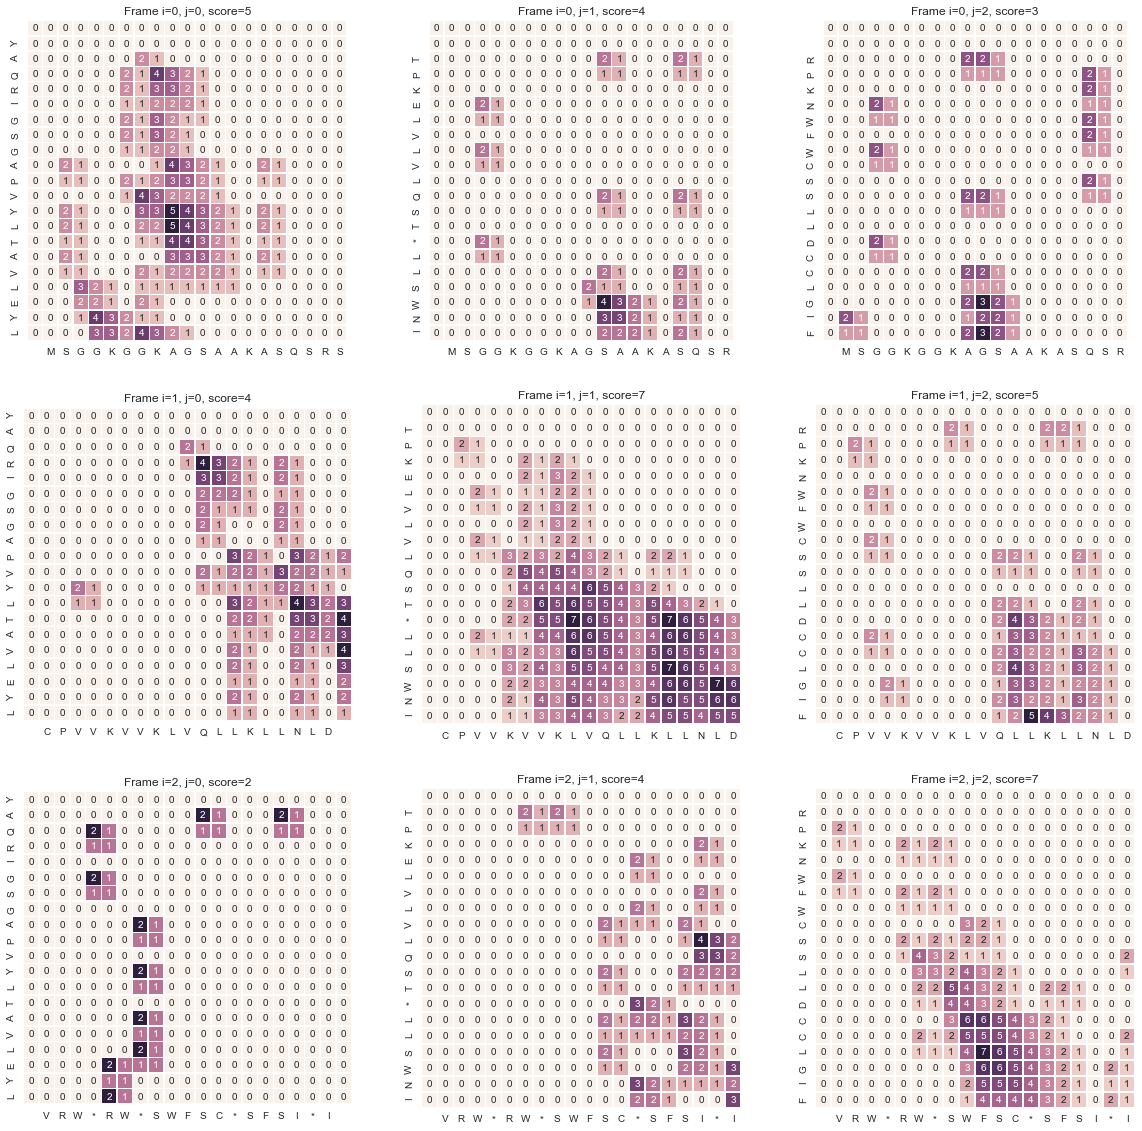

In [95]:
%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt
from Bio.Seq import Seq

fig, axes = plt.subplots(figsize=(20, 20), ncols=3, nrows=3)

for i, j, s1, s2 in get_all_frames(seq1, seq2):
    protein1, protein2 = Seq(s1).translate(), Seq(s2).translate()
    strings, score, matrix = align(protein1, protein2)
    print(protein1, protein2, *strings, score)
    sns.heatmap(matrix, square=True, yticklabels=' ' + protein2, xticklabels=' ' + protein1, 
                      annot=True, linewidths=.5, ax=axes[i, j], fmt='d', cbar=False)
    axes[i, j].set_title(f'Frame i={i}, j={j}, score={score}')